# Features Engineering


Following what have been observed at the initial data exploration stage, here are the main axes of features enginering. We will mostly try to get rid of the noise that is on the signal and to extract its main components. 
- **Frequency domain** : as seen during the epxloration, it could be intersting to compute the Fourier Transform from the data to translate it from the time domain to the frequency domain. (Spark ML offers the possibility to compute DCT = discrete cosine transform that we will use)
- **Statisitcal values** : in order "downsample" the large quantity of data and extract the representative values  

I've worked the data at the segment level first. It's the larger scale we can use as it's the scale of the test set. 
In a second time, I have worked the data on smaller windows inside a segment. 


## 1. Segment scope

In [110]:
import os 

df_train = spark.read.parquet(os.path.join("kdata", "train.vector.parquet"))
df_test = spark.read.parquet(os.path.join("kdata", "test.vector.parquet"))

### 1.1 Frequency domain transformation (segment)

We will then perform some transformation to :
- assemble a large vector covering the whole segment (15,000 x 10 -> 150,000; vx0, vx1, ..., vx9 -> vx )
- perform DCT for the vector (DCT = Discrete Cosine Transform, equivalent of the DFT but computing only the real part, the cosinus part)
- slice the resulting vector to remove the part that are obviously not relevant
- standardize the data using standard deviation

In [111]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import DCT
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import StandardScaler

cols = ["vx"+str(i) for i in range(10)]
assembler = VectorAssembler(inputCols=cols, outputCol="vx_t1")
dct = DCT(inverse=False, inputCol="vx_t1", outputCol="vx_t2")
slicer = VectorSlicer(inputCol="vx_t2", outputCol="vx_t3", indices=[i for i in range(40000)])
scaler = StandardScaler(inputCol="vx_t3", outputCol="vx", withStd=True, withMean=False)

pipeline = Pipeline(stages=[assembler, dct, slicer, scaler])
p_model = pipeline.fit(df_train)

df_train = p_model.transform(df_train)
df_train = df_train.drop("vx0").drop("vx1").drop("vx2").drop("vx3").drop("vx4")
df_train = df_train.drop("vx5").drop("vx6").drop("vx7").drop("vx8").drop("vx9")
df_train = df_train.drop("vx_t1").drop("vx_t2").drop("vx_t3")

df_test = p_model.transform(df_test)
df_test = df_test.drop("vx0").drop("vx1").drop("vx2").drop("vx3").drop("vx4")
df_test = df_test.drop("vx5").drop("vx6").drop("vx7").drop("vx8").drop("vx9")
df_test = df_test.drop("vx_t1").drop("vx_t2").drop("vx_t3")

df_train.write.mode("overwrite").parquet(os.path.join("kdata", "train.vector.dct.parquet"))
df_test.write.mode("overwrite").parquet(os.path.join("kdata", "test.vector.dct.parquet"))

df_train.printSchema()
df_test.printSchema()

root
 |-- seg: long (nullable = true)
 |-- vx: vector (nullable = true)

root
 |-- seg: long (nullable = true)
 |-- vx: vector (nullable = true)



(40000,)

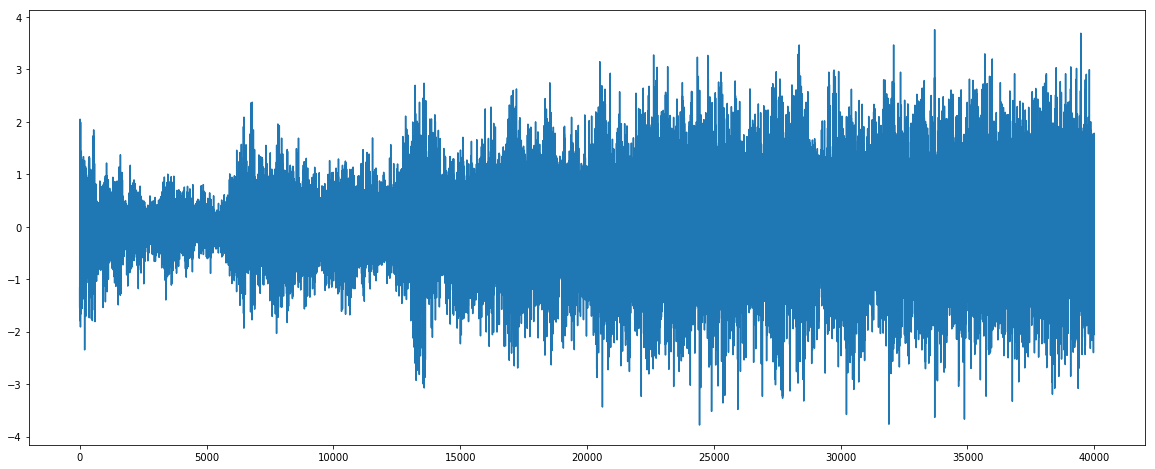

In [120]:
# doublecheck the consistency of the resulting data
df_vect = spark.read.parquet(os.path.join("kdata", "test.vector.dct.parquet"))

import matplotlib.pyplot as plt 
%matplotlib inline

fig = plt.figure(figsize=(20,8))
pdf_vect_seg0 = df_vect.selectExpr("vx").where("seg=1436").toPandas()
y = pdf_vect_seg0['vx'].values.reshape(-1,1)[0][0].toArray()
plt.plot(y[2:])
y.shape


Now we will downsample the data using binning and keeping the absolute value. 

In [121]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

def bin_source_to(source, destination):
    df_v = spark.read.parquet(os.path.join("kdata", source))
    rdd_v = df_v.rdd.map(lambda row:(row.seg, row.vx, []))
    for i in range(0,99):
        rdd_v = rdd_v.map(lambda row, i=i:(row[0], row[1], row[2] + [float(sum(abs(row[1].toArray()[i*400:i*400+800]))/800)]))
    rdd_v = rdd_v.map(lambda row: Row(seg=row[0],f=Vectors.dense(row[2])))      
    df_v = rdd_v.toDF()
    df_v.write.mode("overwrite").parquet(os.path.join("kdata", destination))
    
bin_source_to("train.vector.dct.parquet", "train.vector.fbin.parquet") 
bin_source_to("test.vector.dct.parquet", "test.vector.fbin.parquet") 

(99,)

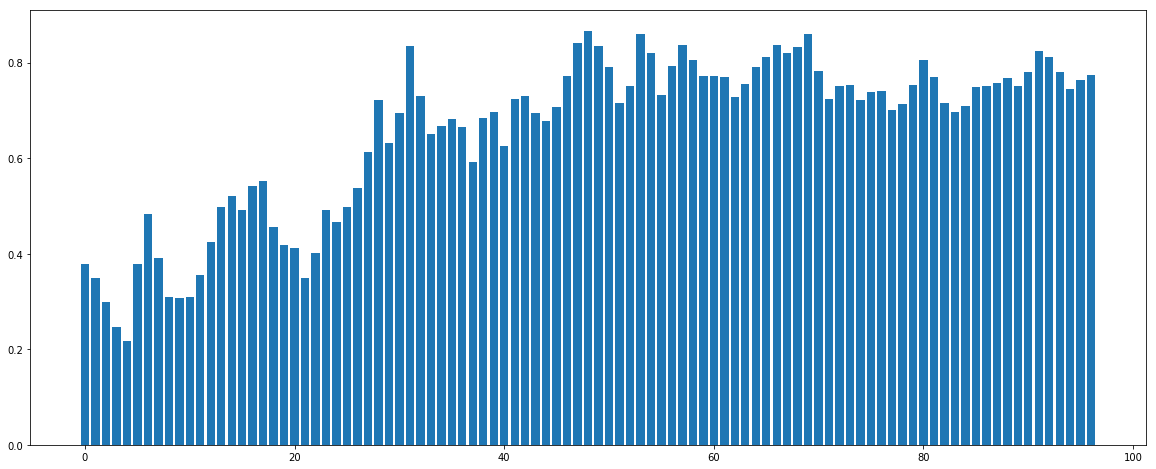

In [116]:
#double check the data produced 

df_v = spark.read.parquet(os.path.join("kdata", "train.vector.fbin.parquet"))

import matplotlib.pyplot as plt 
%matplotlib inline

fig = plt.figure(figsize=(20,8))
pdf_vect_seg0 = df_v.selectExpr("f").where("seg=1436").toPandas()
y = pdf_vect_seg0['f'].values.reshape(-1,1)[0][0].toArray()
plt.bar(range(len(y[2:])), y[2:])
y.shape


After the evaluation of features importance by the random forest model, let's focus on features that seems relevant : range from 50 to 75

In [122]:
from pyspark.ml.feature import VectorSlicer
slicer = VectorSlicer(inputCol="f_t1", outputCol="f", indices=[i for i in range(50,76)])

def slice_source_to(source, destination):
    df_v = spark.read.parquet(os.path.join("kdata", source))
    df_v = df_v.selectExpr("*", "f AS f_t1").drop("_c0").drop("f")
    df_v = slicer.transform(df_v).drop("f_t1")
    df_v.write.mode("overwrite").parquet(os.path.join("kdata", destination))
    
slice_source_to("train.vector.fbin.parquet", "train.vector.fbin.2.parquet")
slice_source_to("test.vector.fbin.parquet", "test.vector.fbin.2.parquet")


### 1.2 Statistical features (segment)

Let's compute a set of statistics and standardize them (using standard deviation) 

In [18]:
df_train = spark.read.parquet(os.path.join("kdata", "train.parquet"))
df_train.createOrReplaceTempView("data")
df_stat = spark.sql("""
SELECT seg,
    AVG(x) AS x_avg,
    STD(x)AS x_std, 
    SKEWNESS(x) AS x_skew, 
    KURTOSIS(x) AS x_kurt, 
    MAX(x) AS x_max,
    PERCENTILE(x, 0.05) AS x_p1,
    PERCENTILE(x, 0.20) AS x_p2,
    PERCENTILE(x, 0.50) AS x_p5,
    PERCENTILE(x, 0.80) AS x_p8,
    PERCENTILE(x, 0.95) AS x_p9,
    AVG(ABS(x)) AS xa_avg,
    STD(ABS(x))AS xa_std, 
    SKEWNESS(ABS(x)) AS xa_skew, 
    KURTOSIS(ABS(x)) AS xa_kurt, 
    MAX(ABS(x)) AS xa_max,
    PERCENTILE(ABS(x), 0.05) AS xa_p1,
    PERCENTILE(ABS(x), 0.20) AS xa_p2,
    PERCENTILE(ABS(x), 0.50) AS xa_p5,
    PERCENTILE(ABS(x), 0.80) AS xa_p8,
    PERCENTILE(ABS(x), 0.95) AS xa_p9
FROM data 
GROUP BY seg
ORDER BY seg
""" )

from pyspark.ml.feature import VectorAssembler
cols = ["x_avg", "x_std", "x_skew", "x_kurt", "x_max", "x_p1", "x_p2", "x_p5", "x_p8", "x_p9", 
        "xa_avg", "xa_std", "xa_skew", "xa_kurt", "xa_max", "xa_p1", "xa_p2", "xa_p5", "xa_p8", "xa_p9"]
assembler = VectorAssembler(inputCols=cols, outputCol="stat_t1")
df_stat = assembler.transform(df_stat)
for col in cols: df_stat = df_stat.drop(col) 

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="stat_t1", outputCol="stat", withStd=True, withMean=False)
scalerModel = scaler.fit(df_stat)
df_stat = scalerModel.transform(df_stat).drop("stat_t1")

df_stat.write.mode("overwrite").parquet(os.path.join("kdata", "train.stat.parquet"))

After testing features on a random forest model and evaluate the features importance, let's focus on features that seems relevant : extreme percentiles

In [ ]:
df_train = spark.read.parquet(os.path.join("kdata", "train.parquet"))
df_train.createOrReplaceTempView("data")
df_stat = spark.sql("""
SELECT seg,
    AVG(x) AS x_avg,
    PERCENTILE(x, 0.01) AS x_p01,
    PERCENTILE(x, 0.02) AS x_p02,
    PERCENTILE(x, 0.05) AS x_p05,
    PERCENTILE(x, 0.10) AS x_p10,
    PERCENTILE(x, 0.90) AS x_p90,
    PERCENTILE(x, 0.95) AS x_p95,
    PERCENTILE(x, 0.98) AS x_p98,
    PERCENTILE(x, 0.99) AS x_p99,
    PERCENTILE(ABS(x), 0.90) AS xa_p90,
    PERCENTILE(ABS(x), 0.92) AS xa_p92,
    PERCENTILE(ABS(x), 0.95) AS xa_p95,
    PERCENTILE(ABS(x), 0.98) AS xa_p98,
    PERCENTILE(ABS(x), 0.99) AS xa_p99
FROM data 
GROUP BY seg
ORDER BY seg
""" )

from pyspark.ml.feature import VectorAssembler
cols = ["x_avg", "x_p01","x_p02","x_p05","x_p10","x_p90","x_p95","x_p98","x_p99",
        "xa_p90","xa_p92","xa_p95","xa_p98","xa_p99"]
assembler = VectorAssembler(inputCols=cols, outputCol="stat_t1")
df_stat = assembler.transform(df_stat)
for col in cols: df_stat = df_stat.drop(col) 

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="stat_t1", outputCol="stat", withStd=True, withMean=False)
scalerModel = scaler.fit(df_stat)
df_stat = scalerModel.transform(df_stat).drop("stat_t1")

df_stat.write.mode("overwrite").parquet(os.path.join("kdata", "train.stat.2.parquet"))

In [1]:
#test set 
df_test = spark.read.parquet(os.path.join("kdata", "test.parquet"))
df_test.createOrReplaceTempView("data")
df_stat = spark.sql("""
SELECT seg,
    AVG(x) AS x_avg,
    STD(x)AS x_std, 
    SKEWNESS(x) AS x_skew, 
    KURTOSIS(x) AS x_kurt, 
    MAX(x) AS x_max,
    PERCENTILE(x, 0.05) AS x_p1,
    PERCENTILE(x, 0.20) AS x_p2,
    PERCENTILE(x, 0.50) AS x_p5,
    PERCENTILE(x, 0.80) AS x_p8,
    PERCENTILE(x, 0.95) AS x_p9,
    AVG(ABS(x)) AS xa_avg,
    STD(ABS(x))AS xa_std, 
    SKEWNESS(ABS(x)) AS xa_skew, 
    KURTOSIS(ABS(x)) AS xa_kurt, 
    MAX(ABS(x)) AS xa_max,
    PERCENTILE(ABS(x), 0.05) AS xa_p1,
    PERCENTILE(ABS(x), 0.20) AS xa_p2,
    PERCENTILE(ABS(x), 0.50) AS xa_p5,
    PERCENTILE(ABS(x), 0.80) AS xa_p8,
    PERCENTILE(ABS(x), 0.95) AS xa_p9
FROM data 
GROUP BY seg
ORDER BY seg
""" )

from pyspark.ml.feature import VectorAssembler
cols = ["x_avg", "x_std", "x_skew", "x_kurt", "x_max", "x_p1", "x_p2", "x_p5", "x_p8", "x_p9", 
        "xa_avg", "xa_std", "xa_skew", "xa_kurt", "xa_max", "xa_p1", "xa_p2", "xa_p5", "xa_p8", "xa_p9"]
assembler = VectorAssembler(inputCols=cols, outputCol="stat_t1")
df_stat = assembler.transform(df_stat)
for col in cols: df_stat = df_stat.drop(col) 

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="stat_t1", outputCol="stat", withStd=True, withMean=False)
scalerModel = scaler.fit(df_stat)
df_stat = scalerModel.transform(df_stat).drop("stat_t1")

df_stat.write.mode("overwrite").parquet(os.path.join("kdata", "test.stat.parquet"))

### 1.3 Target / label collection (segment)

In [21]:
df_train = spark.read.parquet(os.path.join("kdata", "train.parquet"))
df_train.createOrReplaceTempView("data")
df_target = spark.sql("""
SELECT seg, y FROM data 
WHERE no = 150000
ORDER BY seg
""" )
df_target.write.mode("overwrite").parquet(os.path.join("kdata", "train.target.parquet"))

In [95]:
df_test = spark.read.parquet(os.path.join("kdata", "test.parquet"))
df_test.createOrReplaceTempView("data")
df_target = spark.sql("""
SELECT seg, y FROM data 
WHERE no = 150000
ORDER BY seg
""" )
df_target.write.mode("overwrite").parquet(os.path.join("kdata", "test.target.parquet"))

## 2. Window scope

### 2.1 Frequency domain transformation (window)

We will perform the transformation we've done on the segment but at a windows level (10 windows per segment). 
To have enough accuracy on the DCT tranform, we need to take several windows into account and then, slide. I've grouped windows by 3, so the first DCT in on vx0, vx1, vx2, the second DCT on vx1, vx2, vx3, ... ..., and the last DCT on vx7, vx8, vx9.  
- perform DCT for each group of windows vectors 
- slice the resulting vector to keep the most interesting range
- standardize the data using standard deviation

In [4]:
import os 
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import DCT
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import StandardScaler

df_train = spark.read.parquet(os.path.join("kdata", "train.vector.parquet"))
df_test = spark.read.parquet(os.path.join("kdata", "test.vector.parquet"))

for j in range(8):
    cols = ["vx"+str(j+i) for i in range(3)]
    assembler = VectorAssembler(inputCols=cols, outputCol="vx_w"+str(j))
    dct = DCT(inverse=False, inputCol="vx_w"+str(j), outputCol="fr_w"+str(j))
    slicer = VectorSlicer(inputCol="fr_w"+str(j), outputCol="fs_w"+str(j), indices=[i for i in range(12000)])
    scaler = StandardScaler(inputCol="fs_w"+str(j), outputCol="fn_w"+str(j), withStd=True, withMean=False)

    pipeline = Pipeline(stages=[assembler, dct, slicer, scaler])
    pw_model = pipeline.fit(df_train)    

    df_train = pw_model.transform(df_train).drop("vx"+str(j)).drop("vx_w"+str(j)).drop("fr_w"+str(j)).drop("fs_w"+str(j)) 
    df_test = pw_model.transform(df_test).drop("vx"+str(j)).drop("vx_w"+str(j)).drop("fr_w"+str(j)).drop("fs_w"+str(j))  

df_train.write.mode("overwrite").parquet(os.path.join("kdata", "train.win.vector.dct.parquet"))
df_test.write.mode("overwrite").parquet(os.path.join("kdata", "test.win.vector.dct.parquet"))

df_train.printSchema()
df_test.printSchema()

root
 |-- seg: long (nullable = true)
 |-- vx8: vector (nullable = true)
 |-- vx9: vector (nullable = true)
 |-- fn_w0: vector (nullable = true)
 |-- fn_w1: vector (nullable = true)
 |-- fn_w2: vector (nullable = true)
 |-- fn_w3: vector (nullable = true)
 |-- fn_w4: vector (nullable = true)
 |-- fn_w5: vector (nullable = true)
 |-- fn_w6: vector (nullable = true)
 |-- fn_w7: vector (nullable = true)

root
 |-- seg: long (nullable = true)
 |-- vx8: vector (nullable = true)
 |-- vx9: vector (nullable = true)
 |-- fn_w0: vector (nullable = true)
 |-- fn_w1: vector (nullable = true)
 |-- fn_w2: vector (nullable = true)
 |-- fn_w3: vector (nullable = true)
 |-- fn_w4: vector (nullable = true)
 |-- fn_w5: vector (nullable = true)
 |-- fn_w6: vector (nullable = true)
 |-- fn_w7: vector (nullable = true)



(12000,)

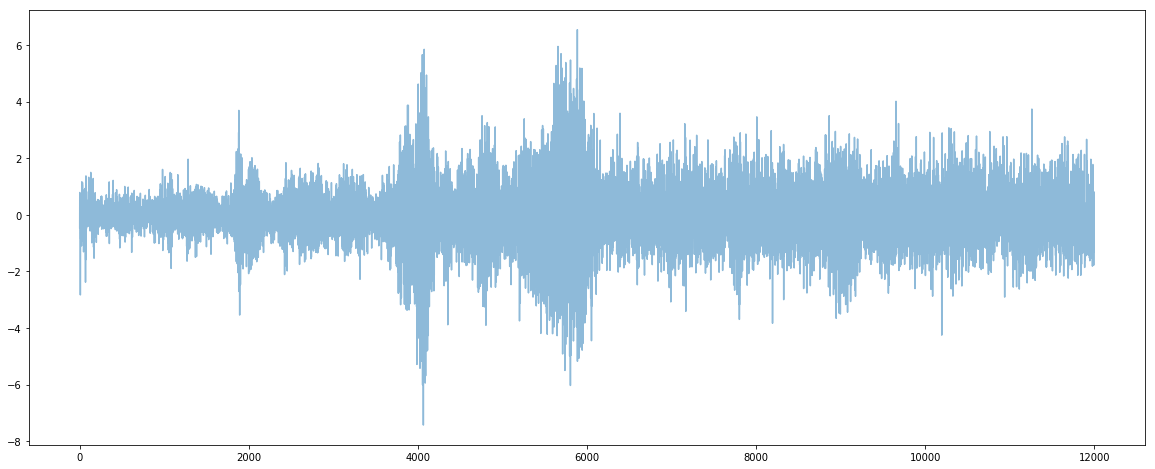

In [5]:
# doublecheck the consistency of the resulting data
df_vect = spark.read.parquet(os.path.join("kdata", "test.win.vector.dct.parquet"))

import matplotlib.pyplot as plt 
%matplotlib inline

fig = plt.figure(figsize=(20,8))
pdf_vect_seg0 = df_train.selectExpr("fn_w4").where("seg=1236").toPandas()
y = pdf_vect_seg0['fn_w4'].values.reshape(-1,1)[0][0].toArray()
plt.plot(y[2:], alpha=0.5)
y.shape


Now we will downsample the data using binning and keeping the absolute value. 

In [14]:
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

def bin_win_source_to(source, destination):
    df_w = spark.read.parquet(os.path.join("kdata", source))
    for j in range(8):
        rdd_w = df_w.rdd.map(lambda row, j=j:(row.seg, row["fn_w"+str(j)], []))
        for i in range(0,99):
            rdd_w = rdd_w.map(lambda row, i=i:(row[0], row[1], row[2] + [float(sum(abs(row[1].toArray()[i*120:i*120+240]))/120)]))
        rdd_w = rdd_w.map(lambda row: Row(seg=row[0],f=Vectors.dense(row[2])))
        df_tmp = rdd_w.toDF()
        df_tmp = df_tmp.selectExpr("seg AS seg2", "f AS f"+str(j)).drop("seg").drop("_c0")
        df_w = df_w.join(df_tmp, df_w.seg.cast(IntegerType()) == df_tmp.seg2.cast(IntegerType())).drop("seg2").drop("fn_w"+str(j))
    df_w = df_w.drop("vx8").drop("vx9")
    df_w.write.mode("overwrite").parquet(os.path.join("kdata", destination))
    
bin_win_source_to("train.win.vector.dct.parquet", "train.win.vector.fbin.parquet")
bin_win_source_to("test.win.vector.dct.parquet", "test.win.vector.fbin.parquet")


(99,)

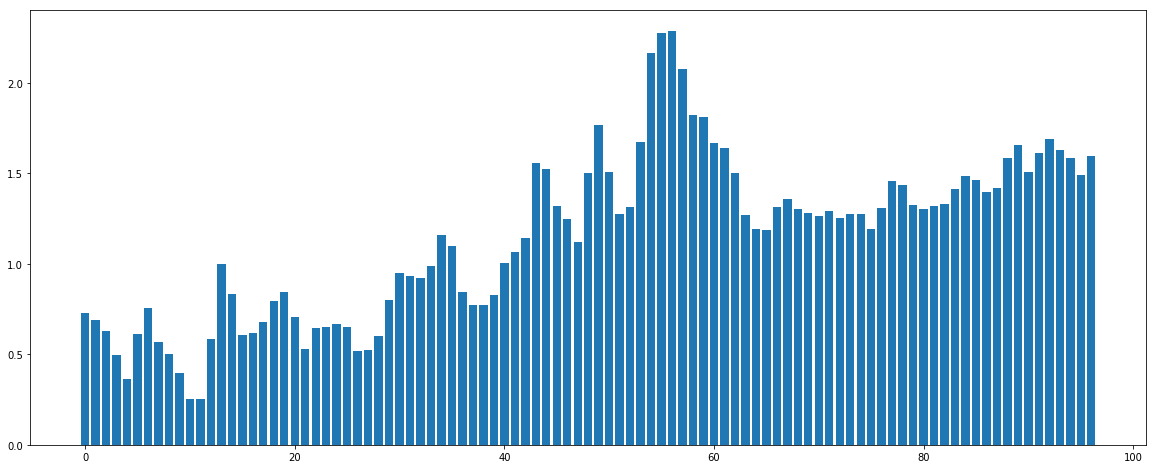

In [15]:
#double check the data produced 
df_v = spark.read.parquet(os.path.join("kdata", "test.win.vector.fbin.parquet"))

import matplotlib.pyplot as plt 
%matplotlib inline

fig = plt.figure(figsize=(20,8))
pdf_vect_seg0 = df_v.selectExpr("f5").where("seg=1436").toPandas()
y = pdf_vect_seg0['f5'].values.reshape(-1,1)[0][0].toArray()
plt.bar(range(len(y[2:])), y[2:])
y.shape


After the evaluation of features importance by the random forest model, let's focus on features that seems relevant : range from 50 to 75

In [16]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import VectorAssembler

def slice_win_source_to(source, destination):
    df_w = spark.read.parquet(os.path.join("kdata", source))
    for j in range(8):
        slicer = VectorSlicer(inputCol="f"+str(j), outputCol="f_sl"+str(j), indices=[i for i in range(50,76)])
        df_w = slicer.transform(df_w).drop("f"+str(j))
    cols = ["f_sl"+str(i) for i in range(8)]
    assembler = VectorAssembler(inputCols=cols, outputCol="f")
    df_w = assembler.transform(df_w) 
    df_w.write.mode("overwrite").parquet(os.path.join("kdata", destination))
    df_w.printSchema()
    
slice_win_source_to("train.win.vector.fbin.parquet", "train.win.vector.fbin.2.parquet")
slice_win_source_to("test.win.vector.fbin.parquet", "test.win.vector.fbin.2.parquet")


root
 |-- seg: long (nullable = true)
 |-- f_sl0: vector (nullable = true)
 |-- f_sl1: vector (nullable = true)
 |-- f_sl2: vector (nullable = true)
 |-- f_sl3: vector (nullable = true)
 |-- f_sl4: vector (nullable = true)
 |-- f_sl5: vector (nullable = true)
 |-- f_sl6: vector (nullable = true)
 |-- f_sl7: vector (nullable = true)
 |-- f: vector (nullable = true)

root
 |-- seg: long (nullable = true)
 |-- f_sl0: vector (nullable = true)
 |-- f_sl1: vector (nullable = true)
 |-- f_sl2: vector (nullable = true)
 |-- f_sl3: vector (nullable = true)
 |-- f_sl4: vector (nullable = true)
 |-- f_sl5: vector (nullable = true)
 |-- f_sl6: vector (nullable = true)
 |-- f_sl7: vector (nullable = true)
 |-- f: vector (nullable = true)



### 2.2 Target / label collection (window)
To improve the training of the recurrent network, we can compute a label for each windows.  

In [45]:
df_train = spark.read.parquet(os.path.join("kdata", "train.parquet"))
df_train.createOrReplaceTempView("data")
df_target = spark.sql("""
SELECT d0.seg, d0.y AS y0, d1.y AS y1, d2.y AS y2, d3.y AS y3, 
               d4.y AS y4, d5.y AS y5, d6.y AS y6, d7.y AS y7
FROM        data AS d0 
INNER JOIN  data AS d1 ON d1.no =  60000 AND d1.seg = d0.seg
INNER JOIN  data AS d2 ON d2.no =  75000 AND d2.seg = d0.seg
INNER JOIN  data AS d3 ON d3.no =  90000 AND d3.seg = d0.seg
INNER JOIN  data AS d4 ON d4.no = 105000 AND d4.seg = d0.seg
INNER JOIN  data AS d5 ON d5.no = 120000 AND d5.seg = d0.seg
INNER JOIN  data AS d6 ON d6.no = 135000 AND d6.seg = d0.seg
INNER JOIN  data AS d7 ON d7.no = 150000 AND d7.seg = d0.seg
WHERE d0.no = 45000
ORDER BY d0.seg
""" )

df_target.write.mode("overwrite").parquet(os.path.join("kdata", "train.win.target.parquet"))

df_target.show()


+---+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|seg|           y0|           y1|           y2|           y3|           y4|           y5|           y6|           y7|
+---+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|  0| 1.4584955403| 1.4541970627| 1.4499985851| 1.4467956019| 1.4424971243| 1.4382986467| 1.4350956635| 1.4307971859|
|  1| 1.4190972475| 1.4148987699| 1.4116957867| 1.4073973091| 1.4031988315| 1.3999958483| 1.3956973707| 1.3914988931|
|  2| 1.3797989547| 1.3765959715| 1.3722974939| 1.3680990163| 1.3648960331| 1.3605975555| 1.3563990779| 1.3531960947|
|  3| 1.3414961563| 1.3371976787| 1.3328992011| 1.3297962179| 1.3254977403| 1.3211992627| 1.3180962795| 1.3137978019|
|  4| 1.3020978635| 1.2977993859| 1.2945964027| 1.2903979251| 1.2860994475| 1.2828964643| 1.2786979867| 1.2743995091|
|  5| 1.2626995707| 1.2594965875| 1.2552981099| 1.250999

### 2.3 Statistical features (window)

In [75]:
df_train = spark.read.parquet(os.path.join("kdata", "train.parquet"))
df_train.createOrReplaceTempView("data")
df_stat = spark.sql("""
SELECT seg,
    INT(no/1000) AS seq,
    AVG(x) AS x_avg,
    PERCENTILE(x, 0.02) AS x_p02,
    PERCENTILE(x, 0.98) AS x_p98,
    PERCENTILE(ABS(x), 0.95) AS xa_p95
FROM data
GROUP BY seg, INT(no/1000)
ORDER BY seg, INT(no/1000)
""" )
df_agg = sc.parallelize([])
rdd_temp = df_stat.rdd.map(lambda row:(row.seg, row.x_avg, row.x_p02, row.x_p98, row.xa_p95))      \
    .map(lambda data: (data[0], ([ data[1] ], [ data[2] ] , [ data[3] ] , [ data[4] ] )))          \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2], a[3] + b[3])  )              \
    .map(lambda row: Row(seg=row[0],
                         stx1=Vectors.dense(row[1][0]),
                         stx2=Vectors.dense(row[1][1]),
                         stx3=Vectors.dense(row[1][2]),
                         stx4=Vectors.dense(row[1][3])))      
# if df_agg.count() == 0: 
df_agg = rdd_temp.toDF(["seg","stx1","stx2","stx3","stx4"])

# df_agg.show()
df_agg = df_agg.select("*").where("seg != 4194")

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="stx1", outputCol="stxn1", withStd=True, withMean=False)
scalerModel = scaler.fit(df_agg)
df_agg = scalerModel.transform(df_agg).drop("stx1")

scaler = StandardScaler(inputCol="stx2", outputCol="stxn2", withStd=True, withMean=False)
scalerModel = scaler.fit(df_agg)
df_agg = scalerModel.transform(df_agg).drop("stx2")

scaler = StandardScaler(inputCol="stx3", outputCol="stxn3", withStd=True, withMean=False)
scalerModel = scaler.fit(df_agg)
df_agg = scalerModel.transform(df_agg).drop("stx3")

scaler = StandardScaler(inputCol="stx4", outputCol="stxn4", withStd=True, withMean=False)
scalerModel = scaler.fit(df_agg)
df_agg = scalerModel.transform(df_agg).drop("stx4")

df_agg.write.mode("overwrite").parquet(os.path.join("kdata", "train.win.stat.parquet"))